In [1]:
from __future__ import print_function
import numpy as np
import torch 
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

def geometricPad(grid, pad=1):
  M = grid.shape[2]; # 0:batchsize, 1:channels, 2:width, 3:height
  M_new = pad+M+pad;
  new_shape = (grid.shape[0], grid.shape[1], M_new, M_new)
  grid_new = grid.new_zeros(new_shape);
  grid_new[:,:,pad:M+pad,pad:M+pad] = grid;
  grid_new[:,:,0:pad,pad:(M+pad)] = grid[:,:,:,0:pad].flip(-1).transpose(-1,-2);
  grid_new[:,:,pad:(M+pad),0:pad] = grid[:,:,0:pad,:].flip(-2).transpose(-1,-2);
  grid_new[:,:,(M+pad):(M+pad+pad),(pad):(M+pad)] = grid[:,:,:,(M-pad):].flip(-1).transpose(-1,-2);
  grid_new[:,:,pad:(M+pad),(M+pad):(M+pad+pad)] = grid[:,:,(M-pad):,:].flip(-2).transpose(-1,-2);
  return(grid_new);

class Taylorizer:
    """Perform taylor expansion of tensor using pre-computed expansion weights"""
    def __init__(self, mGridPmt, mGridCoord, vectorStartIndices, pad=1, Lambda=0.5):
        """
        mGridPmt:   numpy array with (Height,Width) only significance is
                    1. value should be unique for each grid site
                    2. if no PMT exists, set to -1
        mGridCoord: numpy array with (Ncoords,Height,Width)
        vectorStartIndices: array with the start indices of xyz vectors in Ncoords, e.g.
                            for [x,y,z,dirx,diry,dirz] pass [0,3] which treats (x,y,z) and (dirx,diry,dirz)
                            as a vector
        pad:        the taylor expansion will be performed on a grid with sides 2*pad+1
        Lambda:     the regularization strength. should be something of order the differences in mGridCoord
        """
        
        self.mGridPmt   = mGridPmt
        self.mGridCoord = mGridCoord
        self.vectorStartIndices = vectorStartIndices
        self.pad = pad
        self.Lambda = Lambda
        self.rotPhi = 0.
        self.AA = self.computeTaylorWeights()
    
    def cuda(self):
        self.AA = self.AA.cuda()
    
    def cpu(self):
        self.AA = self.AA.cpu()
        
    def __call__(self, inputs):
        return self.taylorize(inputs)

    def computeTaylorWeights(self):
        pad = self.pad
        mGridPmt = self.mGridPmt
        mGridCoord = self.mGridCoord

        Ncoords = mGridCoord.shape[0]
        Ntaylor = 1 + Ncoords # + (Ncoords*(Ncoords+1))//2
        self.Ntaylor = Ntaylor

        M = mGridPmt.shape[0]
        mGridI = np.reshape(np.repeat(np.arange(M),M), (M,M))
        mGridJ = mGridI.transpose()

        Nshift = 2*pad+1
        dij = np.reshape(np.repeat(np.arange(-pad,pad+1),Nshift), (Nshift,Nshift));
        dis = dij.flatten()
        djs = dij.transpose().flatten();
        Nsites = dis.size;
        
        self.dis = dis
        self.djs = djs
        self.Nsites = Nsites

        mGridPmtpad = geometricPad(torch.tensor(mGridPmt).unsqueeze(0).unsqueeze(0), pad).squeeze(0).squeeze(0).numpy();
        mGridIpad = geometricPad(torch.tensor(mGridI).unsqueeze(0).unsqueeze(0), pad).squeeze(0).squeeze(0).numpy();
        mGridJpad = geometricPad(torch.tensor(mGridJ).unsqueeze(0).unsqueeze(0), pad).squeeze(0).squeeze(0).numpy();

        mGridCoordPad = geometricPad(torch.tensor(mGridCoord).unsqueeze(0), pad).squeeze(0).numpy();


        mGridAA2 = np.zeros((M,M,Nshift,Nshift,Ntaylor))

        pmtI1 = mGridPmt[:,:]; # index in tank.pmt

        x      = np.zeros((Ncoords,M,M,Nsites));     # coordinates for each direction
        skip   = np.zeros((M,M,Nsites), dtype=bool); # for each direction whether we should skip or not
        processedPmtI2s = np.zeros((M,M,Nsites), dtype=int) - 1;

        for diji in range(Nsites):
            di = dis[diji]
            dj = djs[diji]
            # i2 = mGridIpad[pad+di:pad+M+di,pad+dj:pad+M+dj];
            # j2 = mGridJpad[pad+di:pad+M+di,pad+dj:pad+M+dj];
            pmtI2 = mGridPmtpad[(pad+di):(pad+M+di),(pad+dj):(pad+M+dj)];
            processedPmtI2s[:,:,diji] = pmtI2;

            skip[:,:,diji] = np.logical_or(np.equal(pmtI1,-1), np.equal(pmtI2,-1));
            for prev_diji in range(diji):
                skip[:,:,diji] = np.logical_or(skip[:,:,diji], np.equal(processedPmtI2s[:,:,prev_diji],pmtI2));

            x[:,:,:,diji] = mGridCoordPad[:,(pad+di):(pad+M+di),(pad+dj):(pad+M+dj)] - mGridCoord; # 

        # x: (Ncoords,M,M,Nsites)
        # print('x.shape:', x.shape)
        # X: (Ntaylor,M,M,Nsites)
        Xlist = [np.expand_dims(np.ones(x.shape[1:]),0),x]
        #for i in range(Ncoords):
        #    Xlist.append(np.stack([x[i,:,:,:] for j in range(Ncoords-i)]) * x[i:,:,:,:])
        X = np.concatenate(Xlist)
        # print('X.shape:', X.shape)
        X = np.where(np.expand_dims(skip, 0), 0., X);

        # regularization strength
        Lambda = self.Lambda; # this should be somewhat smaller than typical values of x

        MA = np.zeros((M,M,Nsites,Nsites));
        for k in range(Nsites):
            for j in range(Nsites):
                MA[:,:,k,j] = np.add(np.sum(X[:,:,:,k]*X[:,:,:,j], axis=0), Lambda**2 * (k==j));
            # clear skip entries
            MA[:,:,k,:] = np.where(np.expand_dims(skip[:,:,k],-1), 0., MA[:,:,k,:]);
            MA[:,:,:,j] = np.where(np.expand_dims(skip[:,:,j],-1), 0., MA[:,:,:,j]);
            # set diagonal:
            MA[:,:,k,k] = np.where(skip[:,:,k], 1., MA[:,:,k,k]);

        #print('MA.shape:',MA.shape)
        #print(MA[0,1,:,:])
        #print(np.linalg.inv(MA[0,1,:,:]))
        print("starting inversion... (may take a few seconds)")
        AA = np.einsum('hwsi,thwi->thws', np.linalg.inv(MA), X)
        print("done")
        # print('AA.shape:', AA.shape)
        return torch.tensor(AA, dtype=torch.float)
    
    def taylorize(self, inputs):
        Batches = inputs.shape[0]
        ChIn    = inputs.shape[1]
        Height  = inputs.shape[2]
        Width   = inputs.shape[3]
        tGridAA = self.AA

        inputsPad = geometricPad(inputs, self.pad); # (B,C,W,H)
        tayloredInput = inputs.new_zeros((Batches, self.Ntaylor, ChIn, Height, Width))
        
        # we use new_zeros and set diagonal to 1, because there is no new_eye method
        rotMatrix = inputs.new_zeros(self.Ntaylor, self.Ntaylor)
        for d in range(self.Ntaylor):
            rotMatrix[d,d] = 1.
        
        for startIndex in self.vectorStartIndices:
            startIndex = 1 + startIndex # the 1 is offset due to scalar
            d_x = 0
            d_y = 1
            rotMatrix[startIndex+d_x,startIndex+d_x] =  np.cos(self.rotPhi);
            rotMatrix[startIndex+d_x,startIndex+d_y] =  np.sin(self.rotPhi); # this is an inverse rotation because w is covariant
            rotMatrix[startIndex+d_y,startIndex+d_x] = -np.sin(self.rotPhi);
            rotMatrix[startIndex+d_y,startIndex+d_y] =  np.cos(self.rotPhi);
        
        #print('tGridAA.shape:', tGridAA.shape)
        #print('tayloredInput.shape:', tayloredInput.shape)
        #print('inputsPad.shape:', inputsPad.shape)
        for k in range(self.Nsites):
            # shift grid according to position (without copying the data)
            inputsPadD1 = torch.narrow(inputsPad,   2, self.pad+int(self.dis[k]), Height)
            inputsPadD2 = torch.narrow(inputsPadD1, 3, self.pad+int(self.djs[k]), Width )
            # fill
            # d,e: directional index (Ntaylor)
            # i,j: grid indices
            # b: event in batch
            # c: channel
            out = torch.add(tayloredInput, torch.einsum('dij,bcij->bdcij', tGridAA[:,:,:,k], inputsPadD2))
            tayloredInput = out
        
        if self.rotPhi != 0.:
            org = tayloredInput
            tayloredInput = torch.einsum('bdcij,ed->becij', org, rotMatrix).contiguous()
            #tayloredInput = out
        
        #print('tayloredInput.shape', tayloredInput.shape, 'to', (Batches, self.Ntaylor*ChIn, Height, Width))
        return tayloredInput.view(Batches, self.Ntaylor*ChIn, Height, Width)
    
    def pool2d(self, kernel_size, pad=-1, Lambda=-1.):
        """
        Return new Taylorizer that can be used for the result of a 2d pool operation with given kernel size.
        kernel_size: e.g. for 2x2 max-pooling use (2,2)
        pad:    if unset (-1)  use same as current
        Lambda: if unset (-1.) use same as current
        """
        mGridPmt1   = torch.nn.functional.max_pool2d(torch.tensor(self.mGridPmt  ).to(torch.float).unsqueeze(0), kernel_size).squeeze(0).to(torch.long).numpy()
        mGridFilled1 = torch.nn.functional.avg_pool2d(torch.tensor((self.mGridPmt >= 0).astype(float)).unsqueeze(0), kernel_size).squeeze(0).numpy()
        
        mGridCoord1 = torch.nn.functional.avg_pool2d(torch.tensor(self.mGridCoord), kernel_size).numpy()
        mGridCoord1 /= mGridFilled1 # correct average for missing positions
        
        if (pad < 0):
            pad = self.pad
        if (Lambda < 0.):
            Lambda = self.Lambda
        
        return Taylorizer(mGridPmt1, mGridCoord1, self.vectorStartIndices, pad=pad, Lambda=Lambda)
    
def imshowRdBu(ax,img):
    minmax = max(torch.max(img),-torch.min(img))
    return ax.imshow(-img,cmap='RdBu',vmin=-minmax,vmax=minmax)

from torch.utils.data import Dataset, DataLoader

class H5Dataset(Dataset):

    def __init__(self, files, transform=None, flavour=None, limit_num_files=0, start_fraction=0., use_fraction=1.0):
        """                                                                                                                                             
        Args: data_dirs ... a list of data directories to find files (up to 10 files read from each dir)                                                
              transform ... a function applied to pre-process data                                                                                      
              flavour ..... a string that is required to be present in the filename                                                                     
              limit_num_files ... an integer limiting number of files to be taken per data directory                                                    
              start_fraction ... a floating point fraction (0.0=>1.0) to specify which entry to start reading (per file)                                
              use_fraction ..... a floating point fraction (0.0=>1.0) to specify how much fraction of a file to be read out (per file)                  
        """
        self._transform = transform
        self._files = []

        # Check input fractions makes sense                                                                                                             
        assert start_fraction >= 0. and start_fraction < 1.
        assert use_fraction > 0. and use_fraction <= 1.
        assert (start_fraction + use_fraction) <= 1.

        # Load files (up to 10) from each directory in data_dirs list                                                                                   
        # for d in data_dirs:
        #     file_list = [ os.path.join(d,f) for f in os.listdir(d) if flavour is None or flavour in f ]
        #     if limit_num_files: file_list = file_list[0:limit_num_files]
        #     self._files += file_list
        self._files = files

        self._file_handles = [None] * len(self._files)
        self._event_to_file_index  = []
        self._event_to_entry_index = []
        import h5py
        for file_index, file_name in enumerate(self._files):
            f = h5py.File(file_name,mode='r')
            data_size = f['event_data'].shape[0]
            start_entry = int(start_fraction * data_size)
            num_entries = int(use_fraction * data_size)
            self._event_to_file_index += [file_index] * num_entries
            self._event_to_entry_index += range(start_entry, start_entry+num_entries)
            f.close()

    def __len__(self):
        return len(self._event_to_file_index)

    def __getitem__(self,idx):
        file_index = self._event_to_file_index[idx]
        entry_index = self._event_to_entry_index[idx]
        if self._file_handles[file_index] is None:
            import h5py
            self._file_handles[file_index] = h5py.File(self._files[file_index],mode='r')
        fh = self._file_handles[file_index]
        label = fh['labels'][entry_index]
        #labelTranslation = [-1,0,1,-1,2] # make sure that labels 1,2,4 get values 0,1,2
        if label == 1: # electron
            label = 0
        elif label == 2: # muon
            label = 1
        elif label == 4: # pip
            label = 2
        else:
            print('Unknown label', label, 'for entry_index', entry_index, 'treating as label=0')
            label = 0
        
        # try:
        #     label = labelTranslation[label]
        # except IndexError:
        #     print('IndexError at entry', entry_index, 'label in file was', fh['labels'][entry_index], 'translations are', labelTranslation)
        #     raise
        
        event_data = fh['event_data'][entry_index]
        Qindex = 0
        Tindex = 1
        Toffset = 990. # ns
        Tnorm = 100. # ns
        event_data[:,:,Tindex] = np.where(event_data[:,:,Tindex]!=0., (event_data[:,:,Tindex]-Toffset)/Tnorm, event_data[:,:,Tindex])
        return event_data[:,:,0:2],label,idx

def HKCollate(batch):
    data  = np.stack([sample[0] for sample in batch])
    label = [sample[1] for sample in batch]
    idx   = [sample[2] for sample in batch]
    rndmRot = np.random.uniform(0., 2*np.pi)
    return data,label,idx,rndmRot

class H5DatasetWithTrack(Dataset):

    def __init__(self, files, transform=None, flavour=None, limit_num_files=0, start_fraction=0., use_fraction=1.0):
        """                                                                                                                                             
        Args: data_dirs ... a list of data directories to find files (up to 10 files read from each dir)                                                
              transform ... a function applied to pre-process data                                                                                      
              flavour ..... a string that is required to be present in the filename                                                                     
              limit_num_files ... an integer limiting number of files to be taken per data directory                                                    
              start_fraction ... a floating point fraction (0.0=>1.0) to specify which entry to start reading (per file)                                
              use_fraction ..... a floating point fraction (0.0=>1.0) to specify how much fraction of a file to be read out (per file)                  
        """
        self._transform = transform
        self._files = []

        # Check input fractions makes sense                                                                                                             
        assert start_fraction >= 0. and start_fraction < 1.
        assert use_fraction > 0. and use_fraction <= 1.
        assert (start_fraction + use_fraction) <= 1.

        # Load files (up to 10) from each directory in data_dirs list                                                                                   
        # for d in data_dirs:
        #     file_list = [ os.path.join(d,f) for f in os.listdir(d) if flavour is None or flavour in f ]
        #     if limit_num_files: file_list = file_list[0:limit_num_files]
        #     self._files += file_list
        self._files = files

        self._file_handles = [None] * len(self._files)
        self._event_to_file_index  = []
        self._event_to_entry_index = []
        import h5py
        for file_index, file_name in enumerate(self._files):
            f = h5py.File(file_name,mode='r')
            data_size = f['event_data'].shape[0]
            start_entry = int(start_fraction * data_size)
            num_entries = int(use_fraction * data_size)
            self._event_to_file_index += [file_index] * num_entries
            self._event_to_entry_index += range(start_entry, start_entry+num_entries)
            f.close()

    def __len__(self):
        return len(self._event_to_file_index)

    def __getitem__(self,idx):
        file_index = self._event_to_file_index[idx]
        entry_index = self._event_to_entry_index[idx]
        if self._file_handles[file_index] is None:
            import h5py
            self._file_handles[file_index] = h5py.File(self._files[file_index],mode='r')
        fh = self._file_handles[file_index]
        label = fh['labels'][entry_index]
        #labelTranslation = [-1,0,1,-1,2] # make sure that labels 1,2,4 get values 0,1,2
        if label == 1: # electron
            label = 0
        elif label == 2: # muon
            label = 1
        elif label == 4: # pip
            label = 2
        else:
            print('Unknown label', label, 'for entry_index', entry_index, 'treating as label=0')
            label = 0
        
        # try:
        #     label = labelTranslation[label]
        # except IndexError:
        #     print('IndexError at entry', entry_index, 'label in file was', fh['labels'][entry_index], 'translations are', labelTranslation)
        #     raise
        
        keys = ['event_data','directions','energies','positions']
        out = {
            "label": label,
            "idx":   idx
        }
        for key in iter(keys):
            out[key] = fh[key][entry_index]
        
        Qindex = 0
        Tindex = 1
        Toffset = 990. # ns
        Tnorm = 100. # ns
        out['event_data'][:,:,Tindex] = np.where(out['event_data'][:,:,Tindex]!=0., (out['event_data'][:,:,Tindex]-Toffset)/Tnorm, out['event_data'][:,:,Tindex])
        return out

def HKCollateWithTrack(batch):
    stack = {}
    for key in iter(batch[0].keys()):
        if key == "event_data" or key == "directions" or key == "energies" or key == "positions":
            stack[key] = np.stack([sample[key] for sample in batch])
        else:
            stack[key] = [sample[key] for sample in batch]
    
    stack["rndmRot"] = np.random.uniform(0., 2*np.pi)
    stack["rndmTimeShift"] = np.random.uniform(0., 1.) # for future use
    return stack
# e.g. positions will have shape (B,2,3) with B=batch-size, 2=(the two particles), 3=(vector coordinates)

class GeomBNConv2d(torch.nn.Module):
    def __init__(self,Cin,Cout,pad):
        super(GeomBNConv2d, self).__init__()
        self.Cin = Cin
        self.Cout = Cout
        self.pad = pad
        self.batchNorm2d = torch.nn.BatchNorm2d(Cin)
        self.conv2d = torch.nn.Conv2d(Cin,Cout,2*self.pad+1)
 
    def forward(self, x):
        x = self.batchNorm2d(x)
        inputsPad = geometricPad(x, self.pad); # (B,C,W,H)
        return self.conv2d(inputsPad)

class Scale2d(torch.nn.Module):
    def __init__(self, C, init_value=None):
        super().__init__()
        if init_value is None:
            init_value = torch.ones(C)
        self.scale = torch.nn.Parameter(torch.FloatTensor(init_value).view((1,C,1,1)))
        
    def forward(self, x):
        return x * self.scale
    
    # the default implementation of cpu() and cuda() only passes this along to nn.Module instances
    # since self.AA is a tensor, we need to take care of it ourselves
    
    def cpu(self):
        super().cpu()
        self.scale.cpu()
        return self
    
    def cuda(self):
        super().cuda()
        self.scale.cuda()
        return self

class ScaleShift2d(torch.nn.Module):
    def __init__(self, C):
        super().__init__()
        init_scale = torch.ones(C)
        init_shift = torch.zeros(C)
        self.scale = torch.nn.Parameter(torch.FloatTensor(init_scale).view((1,C,1,1)))
        self.shift = torch.nn.Parameter(torch.FloatTensor(init_shift).view((1,C,1,1)))
        
    def forward(self, x):
        return x * self.scale + self.shift
    
    # the default implementation of cpu() and cuda() only passes this along to nn.Module instances
    # since self.AA is a tensor, we need to take care of it ourselves
    
    def cpu(self):
        super().cpu()
        self.scale.cpu()
        self.shift.cpu()
        return self
    
    def cuda(self):
        super().cuda()
        self.scale.cuda()
        self.shift.cuda()
        return self

class TaylorSSConv2d(torch.nn.Module):
    def __init__(self,Cin,Cout,taylor):
        super().__init__()
        self.Cin = Cin
        self.Cout = Cout
        self.taylor = taylor
        self.scaleShift2d = ScaleShift2d(Cin*taylor.Ntaylor)
        self.conv2d = torch.nn.Conv2d(Cin*taylor.Ntaylor,Cout,1)
 
    def forward(self, x):
        x = self.taylor(x)
        x = self.scaleShift2d(x)
        x = self.conv2d(x)
        return x
    
    # the default implementation of cpu() and cuda() only passes this along to nn.Module instances
    # since self.AA is a tensor, we need to take care of it ourselves
    
    def cpu(self):
        super().cpu()
        self.taylor.cpu()
        return self
    
    def cuda(self):
        super().cuda()
        self.taylor.cuda()
        return self


class TaylorCNN(torch.nn.Module):
    
    def __init__(self, num_class, taylor):
        super(TaylorCNN, self).__init__()
        
        # prepare taylorizers for maxpool operations
        self.taylor0 = taylor
        self.taylor1 = self.taylor0.pool2d((2,2))
        self.taylor2 = self.taylor1.pool2d((2,2))
        self.taylor3 = self.taylor2.pool2d((2,2))
        #taylor4 = taylor3.pool2d((2,2))
        
        # feature extractor CNN
        self._feature = torch.nn.Sequential(
            # taylor conv
            TaylorSSConv2d( 2, 8,self.taylor0), torch.nn.ReLU(),
            TaylorSSConv2d( 8,16,self.taylor0), torch.nn.ReLU(),
            
            torch.nn.MaxPool2d(2,2),
            TaylorSSConv2d(16,16,self.taylor1), torch.nn.ReLU(),
            TaylorSSConv2d(16,16,self.taylor1), torch.nn.ReLU(),
            
            torch.nn.MaxPool2d(2,2),
            TaylorSSConv2d(16,32,self.taylor2), torch.nn.ReLU(),
            TaylorSSConv2d(32,32,self.taylor2), torch.nn.ReLU(),
            
            torch.nn.MaxPool2d(2,2),
            TaylorSSConv2d(32,64,self.taylor3), torch.nn.ReLU(),
            TaylorSSConv2d(64,64,self.taylor3), torch.nn.ReLU()
        )
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(64+1,32), torch.nn.ReLU(), # the +1 is because of the chrgsum
            torch.nn.Linear(32,num_class)
        )

    def forward(self, x):
        totalCharge = torch.sum(x[:,0,:,:], (1,2)) # resulting shape will be [B]
        net = self._feature(x)
        net = torch.nn.AvgPool2d(net.size()[2:])(net)
        return self._classifier(torch.cat([net.view(-1,64), totalCharge.view(-1,1)], dim=1))
    
    def rot(self, phi):
        self.taylor0.rotPhi = phi
        self.taylor1.rotPhi = phi
        self.taylor2.rotPhi = phi
        self.taylor3.rotPhi = phi
    
    # I'm not sure why I need to implement cpu/cuda myself, train works somehow
    
    def cpu(self):
        super(TaylorCNN, self).cpu()
        for module in self._feature:
            module.cpu()
        for module in self._classifier:
            module.cpu()
        return self
    
    def cuda(self):
        super(TaylorCNN, self).cuda()
        for module in self._feature:
            module.cuda()
        for module in self._classifier:
            module.cuda()
        return self


In [2]:
f = h5py.File('/home/lukasb/projects/rpp-tanaka-ab/lukasb/watchmal/20190808-uniisoflat/1Rmu-blacksheet/wc-0-bch1.h5','r')
event_data = f['event_data'][:]

In [3]:
mGridPmt = f['mGridPmt'][()]
mGridCoord = np.stack([
    # we will intentionally choose different values to without batchnorm so the values tend to be on same order
    f['mGridX'][()]/20.,
    f['mGridY'][()]/20.,
    f['mGridZ'][()]/20.,
    f['mGridDirX'][()]*3.,
    f['mGridDirY'][()]*3.,
    f['mGridDirZ'][()]*3.
])
mGridVectorStartIndices = [0,3]

taylor0 = Taylorizer(mGridPmt, mGridCoord, mGridVectorStartIndices, pad=1, Lambda=1.)

starting inversion... (may take a few seconds)
done


0


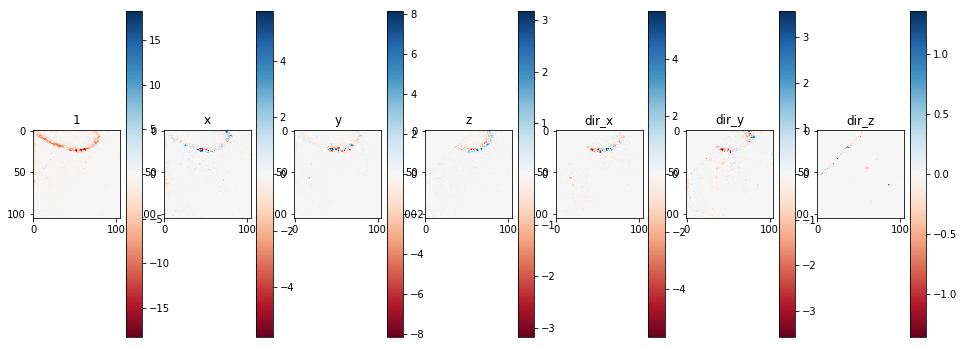

1


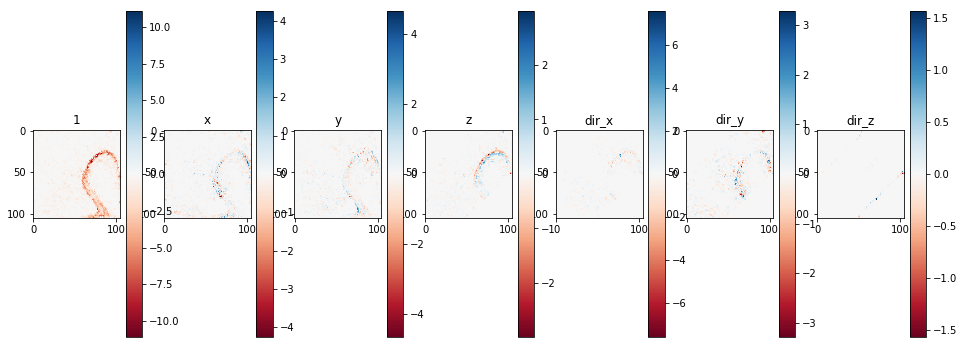

In [4]:
# filters = torch.randn(Cout,Cin,Hflt,Wflt);
inputs = torch.tensor(event_data[(0,5),:,:,0]).unsqueeze(1);
tayloredInput = taylor0(inputs)

for ev in range(tayloredInput.shape[0]):
    print(ev)
    taylorTitles = ['1','x','y','z','dir_x','dir_y','dir_z']
    fig, axes = plt.subplots(1, taylor0.Ntaylor, figsize=(16,8),facecolor='w')
    for itaylor in range(taylor0.Ntaylor):
        im = imshowRdBu(axes[itaylor], tayloredInput[ev,itaylor,:,:]); axes[itaylor].set_title(taylorTitles[itaylor])
        cbar = fig.colorbar(im, ax=axes[itaylor])
    plt.show()

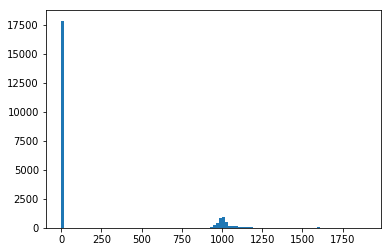

In [5]:
plt.hist(event_data[(0,5),:,:,1].flatten(), bins=100);
plt.show()

In [6]:
mcdir = '/home/lukasb/scratch/20190808-uniisoflat'
wallmat = 'blacksheet'
pnames = ('e')
files = ['%s/1R%s-%s/wc-0-bch%d.h5' % (mcdir,pname,wallmat,bch+1) for bch in range(100) for pname in pnames]

train_ds = H5DatasetWithTrack(files,start_fraction=0.0,use_fraction=0.9);
test_ds  = H5DatasetWithTrack(files,start_fraction=0.9,use_fraction=0.1);

# for training
train_loader=DataLoader(train_ds,batch_size= 64,shuffle=True,num_workers=4,collate_fn=HKCollateWithTrack)
# for validation
test_loader =DataLoader( test_ds,batch_size=200,shuffle=True,num_workers=2,collate_fn=HKCollateWithTrack)

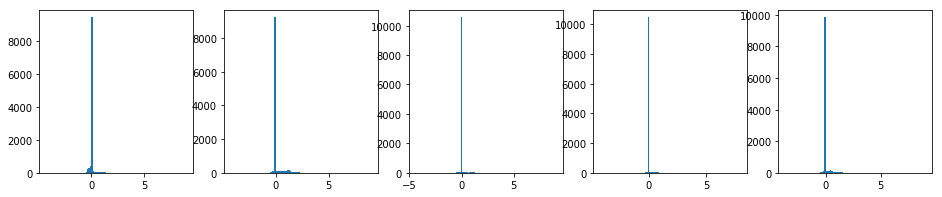

In [7]:
with torch.no_grad():
    Nrows = 5
    iter_train_loader = iter(train_loader)
    Nplot = 5
    fig, axes = plt.subplots(1, Nplot, figsize=(16,3),facecolor='w')
    for r in range(Nrows):
        
        train_data = next(iter_train_loader)
        
        axes[r].hist(train_data['event_data'][0,:,:,1].flatten(), bins=100);
        
        del train_data
    
    plt.show()
    del iter_train_loader

In [8]:
class WeightedLoss(torch.nn.Module):
    # losses should be a list of 2-tuples (Npred,Loss)
    # where Npred is the number of prediction params to use for this loss,
    # and Loss is the loss function to evaluate.
    # The loss functions are applied to the input value in the given order.
    # 
    # the initScale can be a list of typical scales for the losses, which is used to initialize logVar=log(initScales)
    # 
    # from A. Kendall et al., “Multi-Task Learning Using Uncertainty to Weigh Losses for Scene Geometry and Semantics” (2018)
    # the idea is to add weight parameters to the loss function as 
    # totalLoss = sum_i [L_i/V_i + log V_i]
    # such that
    # 0 = d(totalLoss)/dV_i
    #   = -1/V_i^2 [L_i - V_i]
    # so by optimizing V_i, it becomes equal to the typical scale of L_i
    def __init__(self,losses,initScale=None):
        super(WeightedLoss, self).__init__()
        
        self.predPartitions = []
        self.losses = []
        predCumsum = 0
        for Npred,loss in losses:
            self.predPartitions.append((predCumsum,Npred)) # start and length
            predCumsum = predCumsum + Npred
            self.losses.append(loss)
        
        Nlosses = len(losses)
        if initScale is None:
            initScale = np.ones(Nlosses)
        self.logVar = torch.nn.Parameter(torch.log(torch.tensor(initScale, dtype=torch.float)))
        self.logVar.requires_grad = True
 
    def forward(self, pred, true):
        # pred is a 1d tensor with length sum(Npred)
        # true is a normal python list of the true values to pass to each loss function (probably each a tensor)
        oneOverVar = torch.exp(-self.logVar)
        totalLoss = self.logVar.sum()
        for i,loss in enumerate(self.losses):
            thisPred = pred.narrow(1,self.predPartitions[i][0],self.predPartitions[i][1])
            thisTrue = true[i]
            totalLoss = totalLoss + oneOverVar[i]*loss(thisPred,thisTrue)
        
        return totalLoss
    
    # the default implementation of cpu() and cuda() only passes this along to nn.Module instances
    # since self.logSigma is a tensor, we need to take care of it ourselves
    
    def cpu(self):
        super(WeightedLoss, self).cpu()
        self.logVar.cpu()
        return self
    
    def cuda(self):
        super(WeightedLoss, self).cuda()
        self.logVar.cuda()
        return self

In [9]:
loss = WeightedLoss([(3,torch.nn.CrossEntropyLoss()), (1,torch.nn.SmoothL1Loss())])
loss(torch.zeros([1,4]), [torch.tensor([1]),torch.tensor([[0.]])])
print(list(loss.parameters()))

[Parameter containing:
tensor([0., 0.], requires_grad=True)]


In [10]:
def prepareTruth(blob):
    truth = {}
    
    truth['label'] = torch.as_tensor(blob.data['label']).type(torch.LongTensor).cuda()
    truth['label'].requires_grad = False
    
    # the second index is in the case there are two particles
    # for now we simply take the first
    truth['energies'] = torch.as_tensor(blob.data['energies'][:,0:1]).type(torch.FloatTensor).cuda()
    truth['energies'].requires_grad = False
    
    # third index is x,y,z
    # we divide by 100. to convert to m which is closer to the typical scales
    truth['positions'] = torch.as_tensor(blob.data['positions'][:,0:1,:]).type(torch.FloatTensor).cuda() / 100.
    truth['positions'].requires_grad = False
    
    # third index is x,y,z
    truth['directions'] = torch.as_tensor(blob.data['directions'][:,0:1,:]).type(torch.FloatTensor).cuda()
    truth['directions'].requires_grad = False
    
    return truth

def getPredSigmaDim(blob):
    """
        Args: blob: as usual
        Returns: dict with keys "prediction" and "sigma" which give the size of each output
    """
    predIndex  = 0
    sigmaIndex = 0
    
    if blob.predict['energies']:
        predIndex  += 1
        sigmaIndex += 1
    
    if blob.predict['positions']:
        predIndex  += 3
        sigmaIndex += 1
    
    if blob.predict['directions']:
        predIndex  += 3
        sigmaIndex += 1
    
    return {
        "prediction": predIndex,
        "sigma": sigmaIndex
    }

def computeLoss(blob,prediction,sigmas):
    truth = prepareTruth(blob)
    
    loss = {
        'total': 0.
    }
    predIndex  = 0
    sigmaIndex = 0
    
    if blob.predict['energies']:
        logTrueE = torch.log(truth['energies'][:,0])
        logPredE = prediction[:,predIndex]
        neglogsigmaESqr = sigmas[:,sigmaIndex]
        loss['energy'] = torch.mean(torch.pow(logTrueE - logPredE,2)*torch.exp(neglogsigmaESqr) - neglogsigmaESqr)
        loss['total'] += loss['energy']
        predIndex  += 1
        sigmaIndex += 1
    
    if blob.predict['positions']:
        truePos = truth['positions'][:,0,:]
        predPos = prediction[:,(predIndex):(predIndex+3)]
        neglogsigmaPosSqr = sigmas[:,sigmaIndex]
        loss['position'] = torch.mean(torch.sum(torch.pow(truePos - predPos,2),dim=1)*torch.exp(neglogsigmaPosSqr) - neglogsigmaPosSqr)
        loss['total'] += loss['position']
        predIndex  += 3
        sigmaIndex += 1
    
    if blob.predict['directions']:
        trueDir = truth['directions'][:,0,:]              # [B,3]
        predDir = prediction[:,(predIndex):(predIndex+3)] # [B,3]
        neglogsigmaDirSqr = sigmas[:,sigmaIndex]
        # cosine similarity
        predDirNorm = torch.sqrt(torch.sum(torch.pow(predDir,2),dim=1)) # [B]
        loss['direction']     = torch.mean((1. - torch.sum(trueDir*predDir,dim=1)/predDirNorm)*torch.exp(neglogsigmaDirSqr) - neglogsigmaDirSqr)
        loss['directionNorm'] = torch.mean(torch.pow(predDirNorm-1.,2))
        loss['total'] += loss['direction'] + loss['directionNorm']
        predIndex  += 3
        sigmaIndex += 1
    
    return loss


def computeAccuracy(blob,prediction):
    truth = prepareTruth(blob)
    
    Nclasses = 0
    #predLabel = prediction[:,0:Nclasses]
    #softmax    = blob.softmax(predLabel).cpu().detach().numpy()
    #whichLabel = torch.argmax(predLabel,dim=-1)
    #accuracy   = (whichLabel == trueLabel).sum().item() / float(whichLabel.nelement())
    #whichLabel = whichLabel.cpu().detach().numpy()
    # out['accuracy']
    # out['softmax']
    # out['prediction']
    
    out = {}
    predIndex  = Nclasses
    
    if blob.predict['energies']:
        trueE = truth['energies'][:,0]
        predE = torch.exp(torch.clamp(prediction[:,predIndex], -20., 20.))
        energyResolution = torch.mean(torch.pow(predE/trueE - 1.,2))
        energyResolution = energyResolution.cpu().detach().numpy()
        out['energyResolution'] = np.sqrt(energyResolution.mean()).item() # double
        out['predEnergy']       = predE.cpu().detach().numpy() # np.array [batch]
        predIndex += 1
    
    if blob.predict['positions']:
        truePos = truth['positions'][:,0,:]
        predPos = prediction[:,(predIndex):(predIndex+3)]
        posResolution = torch.mean(torch.sqrt(torch.sum(torch.pow(predPos - truePos,2),dim=1)))
        out['positionResolution'] = posResolution.cpu().detach().numpy().item() # double
        out['predPosition']       = predPos.cpu().detach().numpy() # np.array [batch,3]
        predIndex += 3
    
    if blob.predict['directions']:
        trueDir = truth['directions'][:,0,:]
        predDir = prediction[:,(predIndex):(predIndex+3)]
        predDirNorm = torch.sqrt(torch.sum(torch.pow(predDir,2),dim=1)) # [B]
        dirResolution = torch.mean(torch.acos(torch.sum(trueDir*predDir,dim=1)/predDirNorm))
        out['directionResolution'] = dirResolution.cpu().detach().numpy().item() # double
        out['predDirection']       = predDir.cpu().detach().numpy() # np.array [batch,3]
        predIndex += 3
    
    return out

def getLogMessage(blob,res):
    """
        Args: blob (usual), res is output of computeAccuracy
        Returns: log message as string
    """
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f' % (blob.iteration,blob.epoch,res['loss'])
    if blob.predict['label']:
        message += ' ... Accuracy %1.3f' % (res['accuracy'])
    if blob.predict['energies']:
        message += ' ... Eres %1.3f' % (res['energyResolution'])
    if blob.predict['positions']:
        message += ' ... PosRes %.1f m' % (res['positionResolution'])
    if blob.predict['directions']:
        message += ' ... DirRes %.1f mrad' % (res['directionResolution']*1000.)
    return message

def recordToLog(log,blob,res):
    keys = ['iteration','epoch','loss']
    vals = [blob.iteration,blob.epoch,res['loss']]
    
    copyKeys = []
    if blob.predict['label']:
        copyKeys += ['accuracy']
    if blob.predict['energies']:
        copyKeys += ['energyResolution']
    if blob.predict['positions']:
        copyKeys += ['positionResolution']
    if blob.predict['directions']:
        copyKeys += ['directionResolution']
    
    for key in copyKeys:
        keys += [key]
        vals += [res[key]]
    
    log.record(keys,vals)

def forward(blob,train=True):
    """
       Args: blob should have attributes, net, criterion, softmax, data, label
       Returns: a dictionary of predicted labels, softmax, loss, and accuracy
    """
    with torch.set_grad_enabled(train):
        # Prediction
        data = torch.as_tensor(blob.data['event_data']).cuda()
        data = data.permute(0,3,1,2)
        prediction = blob.net(data[:,:,:,:])
        # prediction.shape = (batchSize,nClasses) 
        
        torch.as_tensor(blob.data['energies'][:,0:1]).type(torch.FloatTensor).cuda()
        sigmaData = torch.cat([
            torch.log(torch.as_tensor(blob.data['energies'][:,0:1]).type(torch.FloatTensor)/1000.),
            torch.as_tensor(blob.data['positions'][:,0,:]).type(torch.FloatTensor)/1000.,
            torch.as_tensor(blob.data['directions'][:,0,:]).type(torch.FloatTensor)
        ], dim=1).cuda()
        sigmas = blob.sigmaNet(sigmaData)/100. # make sure it's small enough so it doesn't easily get into the clamping region
        # prediction.shape = (batchSize,NsigmaOut) 
        
        # Training
        blob.loss = computeLoss(blob, prediction, sigmas)
        
        out = computeAccuracy(blob, prediction)
        out['loss'] = blob.loss['total'].cpu().detach().item()
        
        return out

def backward(blob):
    blob.optimizer.zero_grad()  # Reset gradients accumulation
    blob.loss['total'].backward()
    blob.optimizer.step()

def save_state(blob):
    # Output file name
    filename = '%s-%d.ckpt' % (blob.prefix, blob.iteration)
    # Save parameters
    # 0+1) iteration counter + optimizer state => in case we want to "continue training" later
    # 2) network weight
    torch.save({
        'global_epoch': blob.epoch,
        'global_step': blob.iteration,
        'optimizer': blob.optimizer.state_dict(),
        'state_dict': blob.net.state_dict()
        }, filename)
    return filename

def restore_state(blob, iteration):
    # Open a file in read-binary mode
    weight_file = '%s-%d.ckpt' % (blob.prefix, iteration)
    with open(weight_file, 'rb') as f:
        # torch interprets the file, then we can access using string keys
        checkpoint = torch.load(f)
        # load network weights
        blob.net.load_state_dict(checkpoint['state_dict'], strict=False)
        # if optimizer is provided, load the state of the optimizer
        if blob.optimizer is not None:
            blob.optimizer.load_state_dict(checkpoint['optimizer'])
        # load iteration count
        blob.epoch     = checkpoint['global_epoch']
        blob.iteration = checkpoint['global_step']

# weight_file = save_state(blob, '20190819-02-DeepTaylor-01-BatchNorm')
# print('Saved to', weight_file)


# # Recreate the network (i.e. initialize)
# blob.net=LeNet().cuda()
# # Get one batch of data to test
# blob.data, blob.label = next(iter(train_loader))
# # Run forward function
# res = forward(blob,True)
# # Report
# print('Accuracy:',res['accuracy'])



# # Restore the state
# restore_state(weight_file,blob)
# # Run the forward function
# res = forward(blob,True)
# # Report
# print('Accuracy',res['accuracy'])

In [14]:
import math

class BLOB:
    pass

blob=BLOB()
blob.predict = {
    'label':      False,
    'energies':   False,
    'positions':  True,
    'directions': False
}

predSigmaDim = getPredSigmaDim(blob)
NsigmaIn = 7 # E, pos(3), dir(3)

blob.net       = TaylorCNN(predSigmaDim['prediction'], taylor0).cuda() # construct CNN for 1 energy, use GPU
blob.sigmaNet  = torch.nn.Sequential(
    torch.nn.Linear(NsigmaIn,32), torch.nn.ReLU(),
    torch.nn.Linear(32,32), torch.nn.ReLU(),
    torch.nn.Linear(32,predSigmaDim['sigma'])
).cuda()
#blob.optimizer = torch.optim.Adam(list(blob.net.parameters()) + list(blob.sigmaNet.parameters())) # use Adam optimizer algorithm
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
# blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
# blob.mse       = torch.nn.MSELoss()      # not for training, but for accuracy estimation
blob.prefix    = '20200123-07-trackRecoOnly-pos-e-NoBatchNorm'
blob.epoch     = 0.
blob.iteration = 0
blob.data      = None # data for training/analysis

starting inversion... (may take a few seconds)
done
starting inversion... (may take a few seconds)
done
starting inversion... (may take a few seconds)
done


In [15]:
import time
from utils.utils import progress_bar, CSVData

blob.train_log, blob.test_log = CSVData('%s-log_train.csv' % blob.prefix), CSVData('%s-log_test.csv' % blob.prefix)

# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=1.0
# Set the network to training mode
blob.net.train()

# Start training
while int(blob.epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(blob.epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # Data and label
        blob.data  = data
        # blob.net.rot(data['rndmRot'])
        # here we would also need to rotate the truth information (i.e. any vector data in label)
        
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        blob.epoch += 1./len(train_loader)
        blob.iteration += 1
        
        #
        # Log/Report
        #
        # Record the current performance on train set
        recordToLog(blob.train_log, blob, res)
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%3 == 0:
            message = getLogMessage(blob,res)
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%50 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loader))
                blob.data  = test_data
                # blob.net.rot(test_data['rndmRot'])
                res = forward(blob,False)
                recordToLog(blob.test_log, blob, res)
                blob.test_log.write()
            blob.net.train()
        # even more rarely, save state
        if (i+1)%400 == 0:
            with torch.no_grad():
                blob.net.eval()
                save_state(blob)
            blob.net.train()
        if blob.epoch >= TRAIN_EPOCH:
            break
    message = getLogMessage(blob,res)
    #print(message)
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

Epoch 0 Starting @ 2020-03-15 16:57:53


In [16]:
# train more

blob.train_log, blob.test_log = CSVData('%s-log_train.csv' % blob.prefix), CSVData('%s-log_test.csv' % blob.prefix)

# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=5.0
# Set the network to training mode
blob.net.train()

# Start training
while int(blob.epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(blob.epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # Data and label
        blob.data  = data
        # blob.net.rot(data['rndmRot'])
        # here we would also need to rotate the truth information (i.e. any vector data in label)
        
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        blob.epoch += 1./len(train_loader)
        blob.iteration += 1
        
        #
        # Log/Report
        #
        # Record the current performance on train set
        recordToLog(blob.train_log, blob, res)
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%3 == 0:
            message = getLogMessage(blob,res)
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%50 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loader))
                blob.data  = test_data
                # blob.net.rot(test_data['rndmRot'])
                res = forward(blob,False)
                recordToLog(blob.test_log, blob, res)
                blob.test_log.write()
            blob.net.train()
        # even more rarely, save state
        if (i+1)%400 == 0:
            with torch.no_grad():
                blob.net.eval()
                save_state(blob)
            blob.net.train()
        if blob.epoch >= TRAIN_EPOCH:
            break
    message = getLogMessage(blob,res)
    #print(message)
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

Epoch 1 Starting @ 2020-03-15 17:01:13


KeyboardInterrupt: 

In [21]:
list(blob.net._feature[0].scaleShift2d.parameters())

[Parameter containing:
 tensor([[[[1.1327]],
 
          [[1.0747]],
 
          [[1.0573]],
 
          [[0.9001]],
 
          [[1.1424]],
 
          [[1.0839]],
 
          [[1.0554]],
 
          [[0.9264]],
 
          [[1.0159]],
 
          [[0.9730]],
 
          [[1.0103]],
 
          [[0.9290]],
 
          [[0.9749]],
 
          [[0.9935]]]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[[[ 0.0769]],
 
          [[-0.0407]],
 
          [[ 0.0426]],
 
          [[-0.0572]],
 
          [[-0.0738]],
 
          [[ 0.0761]],
 
          [[-0.0574]],
 
          [[-0.0800]],
 
          [[ 0.0442]],
 
          [[-0.1078]],
 
          [[-0.0419]],
 
          [[-0.1296]],
 
          [[-0.0364]],
 
          [[-0.0834]]]], device='cuda:0', requires_grad=True)]

In [49]:
# import time
# from utils.utils import progress_bar, CSVData
# 
# restore_state(blob, 9552)
# blob.train_log, blob.test_log = CSVData('%s-log_train.csv' % blob.prefix), CSVData('%s-log_test.csv' % blob.prefix)

In [50]:
# import pandas as pd
# import matplotlib.pyplot as plt
# %matplotlib inline
# 
# train_log = pd.read_csv(blob.train_log.name)
# test_log  = pd.read_csv(blob.test_log.name)
# 
# fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
# line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
# line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
# ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
# ax1.tick_params('x',colors='black',labelsize=18)
# ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
# ax1.tick_params('y',colors='b',labelsize=18)
# #ax1.set_yscale('log')
# ax1.set_ylim(-0.5,1.)
# 
# ax2 = ax1.twinx()
# line21 = ax2.plot(train_log.epoch, train_log.energyResolution, linewidth=2, label='Train Eres', color='g', alpha=0.3)
# line22 = ax2.plot(test_log.epoch, test_log.energyResolution, marker='o', markersize=12, linestyle='', label='Test Eres', color='green')
# 
# ax2.set_ylabel('Energy resolution', fontsize=24, fontweight='bold',color='g')
# ax2.tick_params('y',colors='g',labelsize=18)
# ax2.set_ylim(0.,3.0)
# 
# # added these four lines
# lines  = line11 + line12 + line21 + line22
# labels = [l.get_label() for l in lines]
# leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
# leg_frame = leg.get_frame()
# leg_frame.set_facecolor('white')
# 
# plt.grid()
# plt.show()

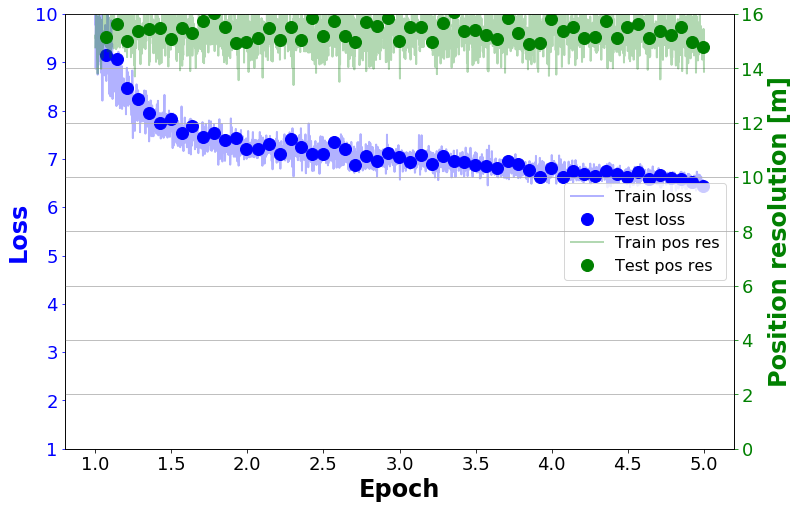

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)
#ax1.set_yscale('log')
ax1.set_ylim(1.,10.)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.positionResolution, linewidth=2, label='Train pos res', color='g', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.positionResolution, marker='o', markersize=12, linestyle='', label='Test pos res', color='green')

ax2.set_ylabel('Position resolution [m]', fontsize=24, fontweight='bold',color='g')
ax2.tick_params('y',colors='g',labelsize=18)
ax2.set_ylim(0.,16.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

In [52]:
# import pandas as pd
# import matplotlib.pyplot as plt
# %matplotlib inline
# 
# train_log = pd.read_csv(blob.train_log.name)
# test_log  = pd.read_csv(blob.test_log.name)
# 
# fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
# line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
# line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
# ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
# ax1.tick_params('x',colors='black',labelsize=18)
# ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
# ax1.tick_params('y',colors='b',labelsize=18)
# #ax1.set_yscale('log')
# ax1.set_ylim(-0.5,1.)
# 
# ax2 = ax1.twinx()
# line21 = ax2.plot(train_log.epoch, train_log.directionResolution, linewidth=2, label='Train dir res', color='g', alpha=0.3)
# line22 = ax2.plot( test_log.epoch,  test_log.directionResolution, marker='o', markersize=12, linestyle='', label='Test dir res', color='green')
# 
# ax2.set_ylabel('Direction resolution [rad]', fontsize=24, fontweight='bold',color='g')
# ax2.tick_params('y',colors='g',labelsize=18)
# ax2.set_ylim(0.,3.0)
# 
# # added these four lines
# lines  = line11 + line12 + line21 + line22
# labels = [l.get_label() for l in lines]
# leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
# leg_frame = leg.get_frame()
# leg_frame.set_facecolor('white')
# 
# plt.grid()
# plt.show()